<a href="https://colab.research.google.com/github/ULLASKM/twitter_sentiment_extract/blob/main/twitter_senti_extract_roberta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Twitter Sentiment Extraction using Roberta Huggingface Transformer

### Problem Statement: Extract support phrases for sentiment labels

With all of the tweets circulating every second it is hard to tell whether the sentiment behind a specific tweet will impact a company, or a person's, brand for being viral (positive), or devastate profit because it strikes a negative tone. Capturing sentiment in language is important in these times where decisions and reactions are created and updated in seconds. But, which words actually lead to the sentiment description? In this competition you will need to pick out the part of the tweet (word or phrase) that reflects the sentiment

I would like to thank Chris Deotte for his wonderful [kernel](https://www.kaggle.com/cdeotte/tensorflow-roberta-0-705/notebook?select=vocab-roberta-base.json) .This gave me intutional knowledge on roberta model.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Loading Data**

In [3]:
df_train = pd.read_csv('/content/drive/My Drive/Mac_ML/twitter-sentiment/train.csv').fillna('')
df_test = pd.read_csv('/content/drive/My Drive/Mac_ML/twitter-sentiment/test.csv').fillna('')
df_train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


# **Importing Libraries**

In [4]:
!pip install transformers

     |████████████████████████████████| 1.3MB 2.7MB/s 
     |████████████████████████████████| 890kB 17.0MB/s 
     |████████████████████████████████| 1.1MB 19.4MB/s 
     |████████████████████████████████| 2.9MB 28.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=19359d87e7c00070fe9ac14fdd456ee1053845a97c7ab2225d0b4128808b5976
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [5]:
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.model_selection import StratifiedKFold
from transformers import *
import tokenizers
print('TF version',tf.__version__)

TF version 2.3.0


## **CONFIG**

1.   Data contains of maximum of 96 word length.
2.   Used HuggingFace tokenizer to convert raw text into tokens.




In [6]:
MAX_LEN = 96
# PATH = '/kaggle/input/tfroberta/TF RoberTa/'
PATH ='/content/drive/My Drive/Mac_ML/twitter-sentiment/'
tokenizer = tokenizers.ByteLevelBPETokenizer(
    PATH+'vocab-roberta-base.json', 
    PATH+'merges-roberta-base.txt', 
    lowercase=True,
    add_prefix_space=True
)
sentiment_id = {'positive': 1313, 'negative': 2430, 'neutral': 7974}

train_col = df_train.shape[0]
# Initialising training inputs
input_ids=np.ones((train_col,MAX_LEN),dtype="int32")          # Array with value 1 of shape(27481,96)
attention_mask=np.zeros((train_col,MAX_LEN),dtype="int32")    # Array with value 0 of shape(27481,96)
token_type_ids=np.zeros((train_col,MAX_LEN),dtype="int32")    # Array with value 0 of shape(27481,96)
start_tokens=np.zeros((train_col,MAX_LEN),dtype="int32")      # Array with value 0 of shape(27481,96)
end_tokens=np.zeros((train_col,MAX_LEN),dtype="int32")        # Array with value 0 of shape(27481,96)

# Converting raw text into tokens which serves as input form for Roberta Model

## One Sample Instance,

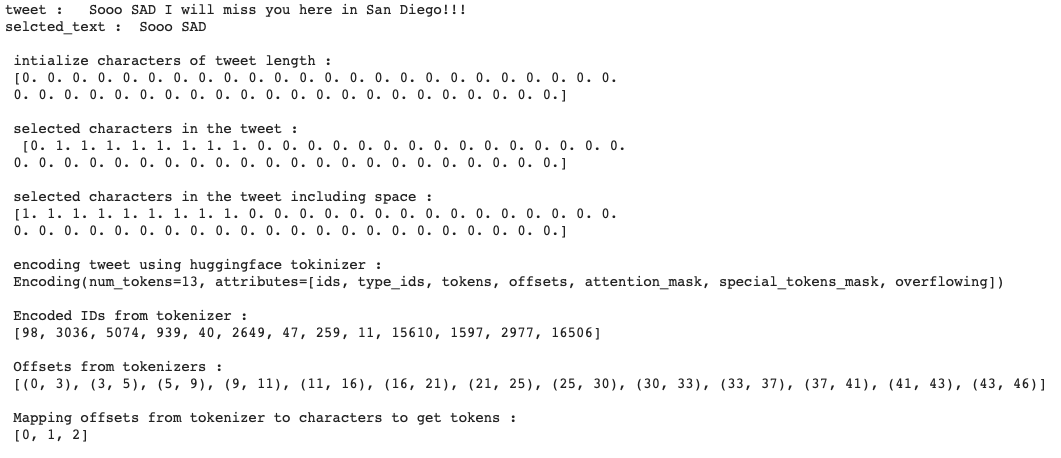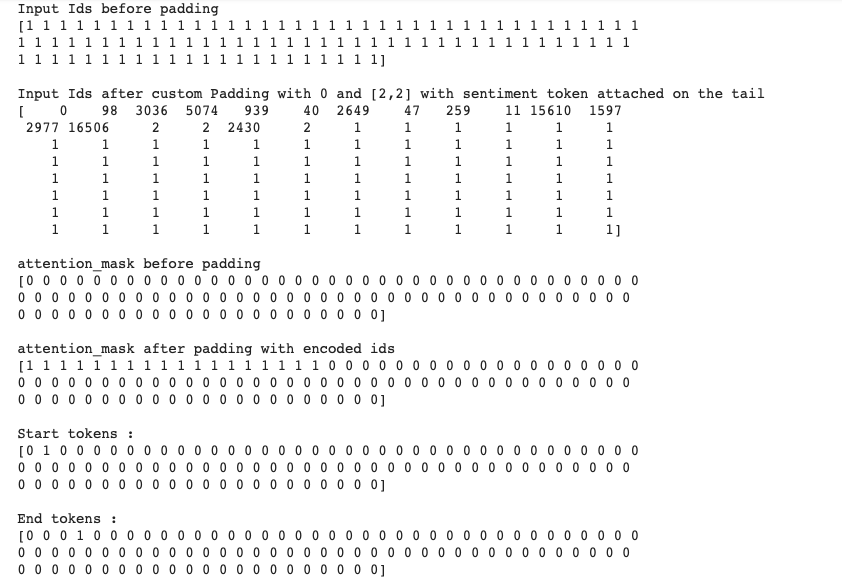

In [7]:
for k in range(df_train.shape[0]):
    
    # FIND OVERLAP
    tweet = " "+" ".join(df_train.loc[k,'text'].split())
    selected_text = " ".join(df_train.loc[k,'selected_text'].split())
    idx = tweet.find(selected_text)
    chars = np.zeros((len(tweet)))      # intialize characters of tweet length
    chars[idx:idx+len(selected_text)]=1         # selected characters in the tweet 
    if tweet[idx-1]==' ':               # checking the space characters
      chars[idx-1] = 1                  # selected characters in the tweet including space  
    enc = tokenizer.encode(tweet)       # encoding tweet using huggingface tokinizer 
        
    # ID_OFFSETS
    offsets = enc.offsets               # Offsets from tokenizers 
    
    # START END TOKENS
    tokens = []
    for i,(a,b) in enumerate(offsets):
        sm = np.sum(chars[a:b])
        if sm>0: 
          tokens.append(i)              # Mapping offsets from tokenizer to characters to get tokens    

    
    senti_tokens = sentiment_id[df_train.loc[k,'sentiment']]    
    
    # Input Ids after custom Padding with 0 and [2,2] with sentiment token attached on the tail 
    input_ids[k,:len(enc.ids)+5] = [0] + enc.ids + [2,2] + [senti_tokens] + [2] 

    attention_mask[k,:len(enc.ids)+5] = 1     # attention_mask after padding with encoded ids  

    if len(tokens)>0:
        start_tokens[k,tokens[0]+1] = 1       # Start tokens
        end_tokens[k,tokens[-1]+1] = 1        # End tokens

# Test Data

In [8]:
test_col = df_test.shape[0]
input_ids_test = np.ones((test_col,MAX_LEN),dtype='int32')
attention_mask_test = np.zeros((test_col,MAX_LEN),dtype='int32')
token_type_ids_test = np.zeros((test_col,MAX_LEN),dtype='int32')

for k in range(test_col):
        
    # INPUT_IDS
    tweet = " "+" ".join(df_test.loc[k,'text'].split())
    enc = tokenizer.encode(tweet)                
    senti_tokens = sentiment_id[df_test.loc[k,'sentiment']]
    input_ids_test[k,:len(enc.ids)+5] = [0] + enc.ids + [2,2] + [senti_tokens] + [2]
    attention_mask_test[k,:len(enc.ids)+5] = 1

# **Model**

a) Pre-trained-Model: (TFRobertaQA model was not yet released)

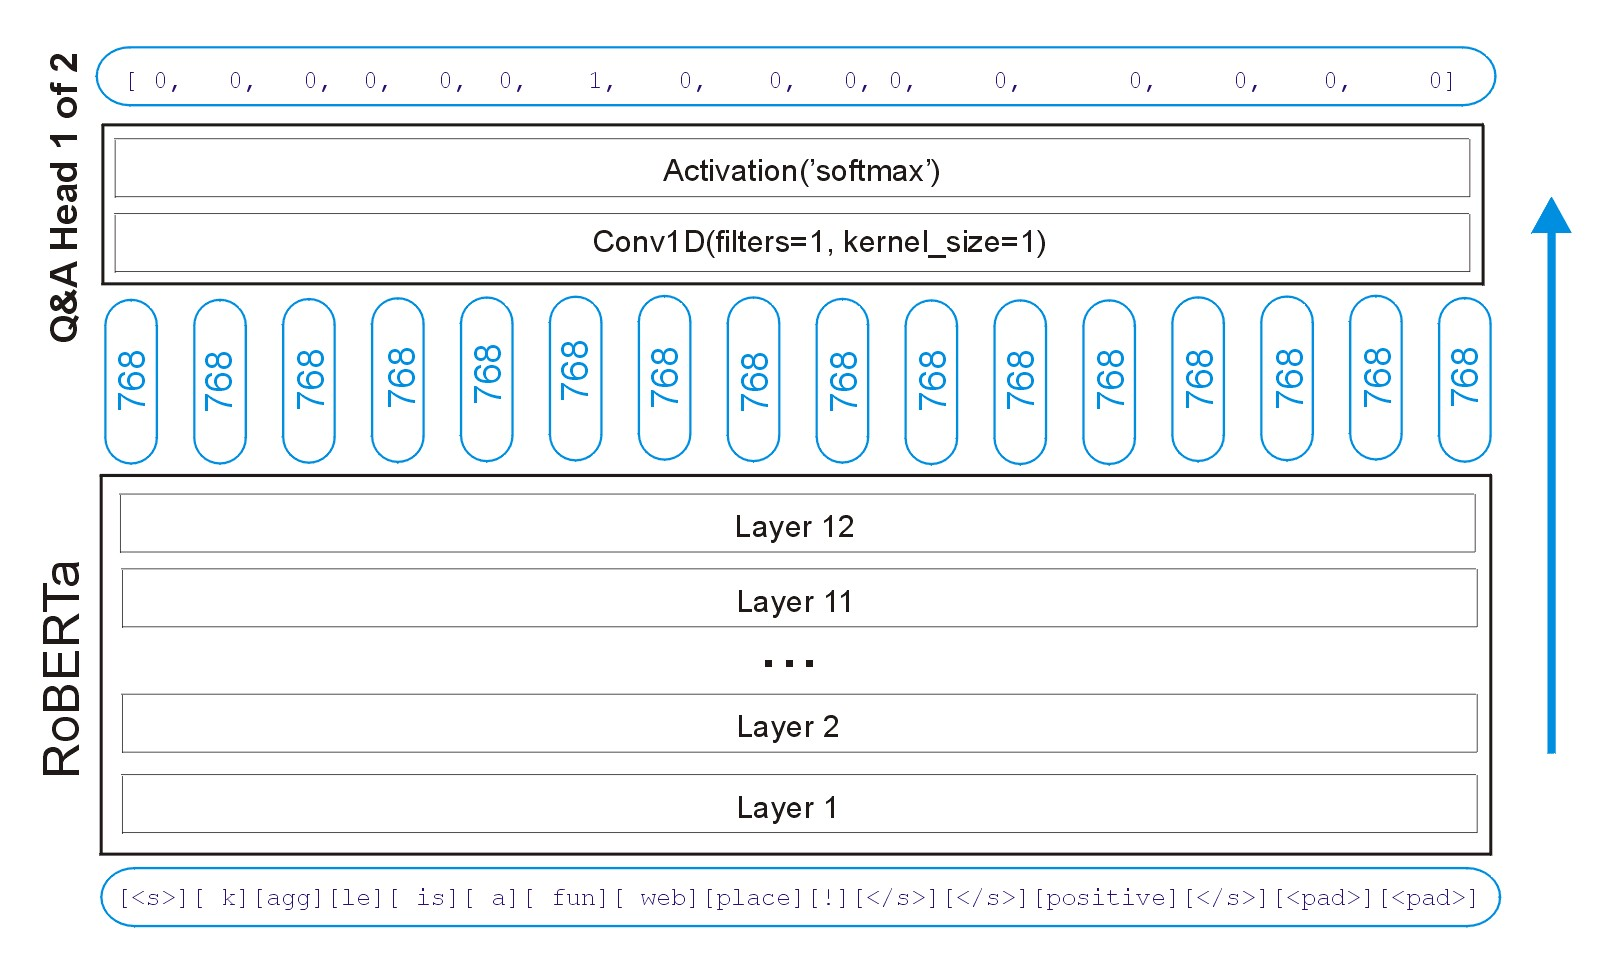

1. We use a pretrained-Roberta-base-model and upon that we add a custom 
question answer head layer (TFRobertaQA model was not yet released). 

2. First tokens are input into bert_model and we use BERT's first output, i.e. x[0] below. These are embeddings of all input tokens and have shape (batch_size, MAX_LEN, 768). 

3. Next we apply tf.keras.layers.Conv1D(filters=1, kernel_size=1) and transform the embeddings into shape (batch_size, MAX_LEN, 1). 

4. We then flatten this and apply softmax, so our final output from x1 has shape (batch_size, MAX_LEN). These are one hot encodings of the start tokens indicies (for selected_text). And x2 are the end tokens indicies.

b) Loading Pre-trained model weights :

1. By using 5 folds Pretrained model weights and with leakyRelu layer on it we predict start and end indices of selected_text.


In [9]:
def build_model():
    ids = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    att = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    tok = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)

    config = RobertaConfig.from_pretrained(PATH+'config-roberta-base.json')
    bert_model = TFRobertaModel.from_pretrained(PATH+'pretrained-roberta-base.h5',config=config)
    x = bert_model(ids,attention_mask=att,token_type_ids=tok)
    
    x1 = tf.keras.layers.Dropout(0.1)(x[0]) 
    x1 = tf.keras.layers.Conv1D(1,1)(x1)
    x1 = tf.keras.layers.LeakyReLU()(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Activation('softmax')(x1)
    
    x2 = tf.keras.layers.Dropout(0.1)(x[0]) 
    x2 = tf.keras.layers.Conv1D(1,1)(x2)
    x2 = tf.keras.layers.LeakyReLU()(x2)
    x2 = tf.keras.layers.Flatten()(x2)
    x2 = tf.keras.layers.Activation('softmax')(x2)

    # Initializing input,output for model.THis will be trained in next code
    model = tf.keras.models.Model(inputs=[ids, att, tok], outputs=[x1,x2])
    
    #Adam optimizer for stochastic gradient descent. if you are unware of it - https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
    model.compile(loss='binary_crossentropy', optimizer=optimizer)

    return model

model = build_model()
model.summary()

All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at /content/drive/My Drive/Mac_ML/twitter-sentiment/pretrained-roberta-base.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 96)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 96)]         0                                            
__________________________________________________________________________________________________
tf_roberta_model (TFRobertaMode ((None, 96, 768), (N 124645632   input_1[0][0]                    
                                                                 input_2[0][0]         

# Evaluation Metric (Jaccard)

In [10]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    if (len(a)==0) & (len(b)==0): return 0.5
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

# Training

In [12]:
jac = []; 
VER='v0'; 
DISPLAY=1 # USE display=1 FOR INTERACTIVE
oof_start = np.zeros((input_ids.shape[0],MAX_LEN))
oof_end = np.zeros((input_ids.shape[0],MAX_LEN))
preds_start = np.zeros((input_ids_test.shape[0],MAX_LEN))
preds_end = np.zeros((input_ids_test.shape[0],MAX_LEN))

skf = StratifiedKFold(n_splits=3,shuffle=True,random_state=777)
for fold,(idxT,idxV) in enumerate(skf.split(input_ids,df_train.sentiment.values)):

    print('#'*25)
    print('### FOLD %i'%(fold+1))
    print('#'*25)
    
    K.clear_session()
    model = build_model()
        
    # Pretrained model
    print('Loading Pretrained Model...')
    model.load_weights('/content/drive/My Drive/Mac_ML/twitter-sentiment/model-v0-roberta-%i.h5'%fold)
   
    print('Predicting OOF...')
    oof_start[idxV,],oof_end[idxV,] = model.predict([input_ids[idxV,],
                                                     attention_mask[idxV,],
                                                     token_type_ids[idxV,]],
                                                     verbose=DISPLAY)
    
    print('Predicting Test...')
    preds = model.predict([input_ids_test,
                           attention_mask_test,
                           token_type_ids_test],
                           verbose=DISPLAY)
    
    preds_start += preds[0]/skf.n_splits
    preds_end += preds[1]/skf.n_splits
    
    # DISPLAY FOLD JACCARD
    all = []
    for k in idxV:
        a = np.argmax(oof_start[k,])
        b = np.argmax(oof_end[k,])
        if a>b: 
            st = df_train.loc[k,'text']
        else:
            text1 = " "+" ".join(df_train.loc[k,'text'].split())
            enc = tokenizer.encode(text1)
            st = tokenizer.decode(enc.ids[a-1:b])
        all.append(jaccard(st,df_train.loc[k,'selected_text']))
    jac.append(np.mean(all))
    print('>>>> FOLD %i Jaccard ='%(fold+1),np.mean(all))
    print()

#########################
### FOLD 1
#########################


All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at /content/drive/My Drive/Mac_ML/twitter-sentiment/pretrained-roberta-base.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Loading Pretrained Model...
Predicting OOF...
287/287 [==============================] - 108s 376ms/step
Predicting Test...
111/111 [==============================] - 42s 375ms/step
>>>> FOLD 1 Jaccard = 0.7317540662447076

#########################
### FOLD 2
#########################


All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at /content/drive/My Drive/Mac_ML/twitter-sentiment/pretrained-roberta-base.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Loading Pretrained Model...
Predicting OOF...
287/287 [==============================] - 108s 375ms/step
Predicting Test...
111/111 [==============================] - 41s 372ms/step
>>>> FOLD 2 Jaccard = 0.7214959901769391

#########################
### FOLD 3
#########################


All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at /content/drive/My Drive/Mac_ML/twitter-sentiment/pretrained-roberta-base.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Loading Pretrained Model...
Predicting OOF...
287/287 [==============================] - 108s 376ms/step
Predicting Test...
111/111 [==============================] - 42s 375ms/step
>>>> FOLD 3 Jaccard = 0.7431501134829902



In [13]:
print('>>>> OVERALL KFold CV Jaccard =',np.mean(jac))

>>>> OVERALL KFold CV Jaccard = 0.7321333899682122


# Prediction on Test Data

In [14]:
all = []
for k in range(input_ids_test.shape[0]):
    a = np.argmax(preds_start[k,])
    b = np.argmax(preds_end[k,])
    if a>b: 
        selected_txt = df_test.loc[k,'text']
    else:
        tweet = " "+" ".join(df_test.loc[k,'text'].split())
        enc = tokenizer.encode(tweet)
        selected_txt = tokenizer.decode(enc.ids[a-1:b])
    all.append(selected_txt)

# Submission File

In [15]:
df_test['selected_text'] = all
df_test[['textID','selected_text']].to_csv('submission.csv',index=False)
pd.set_option('max_colwidth', 60)
df_test.sample(25)

,textID,text,sentiment,selected_text
1175,c8a8b0e791,is tired. And turning off the Internet. You can play on ...,negative,is tired.
295,dbd82ea5bd,its hilarious,positive,its hilarious
1873,88375a5f3e,"Laura`s gone for the weekend, I miss her already!",negative,miss
796,43449f0068,_laura_LP ok thanks for the help! I hope they respond to...,positive,thanks for the help! i hope they respond to me sooner o...
1579,f40d533a23,got all A`s,neutral,got all a`s
1445,f7638c4126,(RE:'your joint w/ is crazy!!') Thx Hey Trax heard ...,positive,thx
2697,f245456ba5,"thanks iPhone, you kept me up till 1 am. ****.",neutral,"thanks iphone, you kept me up till 1 am. ****."
802,8b8932427d,"Oh..Summer begins..yay.. The fighting, Crying and stres...",negative,stress
1028,57ea442d4d,**** i wanna see the rest!! i only saw like 30 minutes,negative,****
798,38e8111514,"awww that sucks also, when i finish uni, you should to...",negative,awww that sucks
